# HW1, COMS 4995_005, Deep Learning

## Max Possible Score 120 Points  (100 + 20 Extra Credits)
----

# Part1: (Basic Neural Nework) (70 Points)

### Part 1.1:

- Divide the training data into 80% training set and 20% validation set. 
- Implement the functions in the ipython notebook so that you can train your network. 
- Your code should take network structure, training data, hyperparameters and generate validation set accuracy.
- Use Relu activation for intermediate layers and use cross entropy loss after taking softmax on the output of the final layer.


Plot a graph of loss (plot loss on training set and val set both) vs Iterations (which would be decreasing with probably some noise) - **60 Points**


### Part 1.2:

Test your model accuracy on test set. If it is more than **47%**, you will get an additional score of **10 points**

# Part 2: (Regularization) (30 Points)

### Part 2.1 (15 Points) :

Modify code to add L2 regularization. Report the validation accuracy.

You should get a validation and test accuracy of more than the one reported in Part-1

Plot a graph of loss (plot loss on training set and val set both) vs Iterations (which would be decreasing with probably some noise) 


### Part 2.2 (15 Points):

You should get a validation and test accuracy crossing **50%**


# Extra Credit (20 Points)

Show your excitement on deep learning! Top **3 scorers** will get these **20 points**

**(note that you cannot use convolutional layers in this part also)**

(Hints) Boost your accuracy by trying out: 
- Dropout Regularization
- Batch Normalization
- Other optimizers like Adam
- Learning Rate Decay
- Data Augmentation 
- Different Initializations for weights like Xaviers etc.


------------

## Code Guidelines:

1. Write your code in **Python 3**.
2. **DONOT** import any other packages.
3. Click **https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz** -> download **cifar-10-python.tar.gz** -> extract as **cifar-10-python**
4. Ensure that **this ipython notebook** and **cifar-10-python** folder are in the same folder.


-------------------



## Submission Guidelines:

1. Run this ipython notebook once and submit this file. Ensure that the outputs are printed properly. We will first see the outputs, if there are no outputs, we may not run the notebook at all.
2. Training on the **test data** is considered cheating. If we find any clue of that happening, then we will disqualify the submission and it will be reported accordingly.
3. Each team member needs to separately submit the the file named uni.ipynb on courseworks.
------------

## Team Information

Team Member1 (Name,UNI): Huibo Zhao hz2480

Team Member2 (Name, UNI): Tingmeng Li tl2758

In [1]:
import numpy as np
import pickle
import copy
%matplotlib inline
import matplotlib.pyplot as plt
# Do not import other packages

In [94]:
class FullyConnectedNetwork(object):
    """
    Abstraction of a Fully Connected Network.
    Stores parameters, activations, cached values. 
    You can add more functions in this class, and also modify inputs and outputs of each function
    
    """
    def __init__(self, layer_dim, lambd=0):
        """
        layer_dim: List containing layer dimensions. 
        
        Code:
        Initialize weight and biases for each layer
        """
        
        self.xAxis = []
        self.yTrain = []
        self.yVal = []
        
        # initialize weight and biases as dictionaries
        self.W = {}
        self.b = {}
        
        # initialize cache (used in backpropagation) as dictionaries
        self.cacheAffine = {}
        self.cacheRelu = {}
    
        # other initialization
        self.lambd = lambd
        self.num_layers = len(layer_dim)
        
        for i in range(1, self.num_layers):
            ### normal distribution for randomalize ###
            self.W[i] = 0.01 * np.random.randn(layer_dim[i],layer_dim[i-1]) 
            self.b[i] = 0.01 * np.random.randn(layer_dim[i],1)

    def feedforward(self,X,eval=0):
        """
        Expected Functionality: 
        Returns output of the neural network for input X. Also returns cache, which contains outputs of 
        intermediate layers which would be useful during backprop.

        """
        
        # for layers except last layer
            # affineForward
            # relu_forward
    
        # last layer
            # affineForward
            
            
        temp_input = X.copy()
        
        
        #### when we use feedforward for evaluation, we don't want to update cache! ###
        if (eval == 1):
            for i in range(1,self.num_layers):
                affine_temp_out, no_use = self.affineForward(temp_input,self.W[i],self.b[i])
                if (i == self.num_layers-1):
                    return affine_temp_out
                temp_input = self.relu_forward(affine_temp_out)
        #################################################################################
        
        for i in range(1,self.num_layers):
            affine_temp_out, self.cacheAffine[i] = self.affineForward(temp_input, self.W[i],self.b[i])
            if (i == self.num_layers-1): # the last layer is output layer
                break
            temp_input = self.relu_forward(affine_temp_out)
            self.cacheRelu[i] = temp_input
        
        return affine_temp_out
            
            
    def loss_function(self, At, Y):
        """
        At is the output of the last layer, returned by feedforward.
        Y contains true labels for this batch.
        this function takes softmax the last layer's output and calculates loss.
        the gradient of loss with respect to the activations of the last layer are also returned by this function.
        
        """
        num_samples = At.shape[1] # number of samples
        
        softmax_output = np.exp(At - np.average(At,axis=0)) # do exponential to each element
                                                                           # subtract average from each
                                                                           # element won't affect final result
        
        temp_sum = np.sum(softmax_output,axis=0,keepdims=True) # sum(e^a[j])
        softmax_output = softmax_output / temp_sum # softmax done
        
        # for computing the gradient of loss with respect to the activations of the last layer
        # dC/dh = y_i (prediction) - t_i (target value)
        # Therefore, we only need to minus one for those corresponding to the correct target value
        
        dAt = softmax_output.copy()
        dAt [Y,np.arange(num_samples)] -= 1
        
        # for computing average cost of all samples, we extract true class's softmax value
        # and apply -log to them and then sum them up and lastly divided by the total numbers
        ave_loss = np.sum(-np.log(softmax_output[Y,np.arange(num_samples)])) / num_samples
        
        return ave_loss, dAt

        # softmax: e^a(i) / (sum(e^a[j]) for j in all classes)
        # cross entropy loss:  -log(true class's softmax value(prediction))
    
        # for part2: when lambd > 0, you need to change the definition of loss accordingly
        
    def train(self, X, Y, max_iters=5000, batch_size=100, learning_rate=0.01, validate_every=200):
        """
        X: (3072 dimensions, 50000 examples) (Cifar train data)
        Y: (1 dimension, 50000 examples)
        lambd: the hyperparameter corresponding to L2 regularization
        
        Divide X, Y into train(80%) and val(20%), during training do evaluation on val set
        after every validate_every iterations and in the end use the parameters corresponding to the best
        val set to test on the Cifar test set. Print the accuracy that is calculated on the val set during 
        training. Also print the final test accuracy. Ensure that these printed values can be seen in the .ipynb file you
        submit.
        
        Expected Functionality: 
        This function will call functions feedforward, backprop and update_params. 
        Also, evaluate on the validation set for tuning the hyperparameters.
        """
        # generate training data index
        index = np.random.choice(50000,50000,replace=False)
        train_index = index[0:40000]
        val_index = index[40000:50000]
        
        train_X = X[:,train_index]
        train_Y = Y[:,train_index]
        
        val_X = X[:,val_index]
        val_Y = Y[:,val_index]
        

        # for some iterations
            # get current batch
            # feedforward
            # loss_function
            # backprop
            # updateParameters
        temp_W = self.W.copy()
        temp_b = self.W.copy()
        best_accuracy = 0
        for i in range(max_iters):
            batch_X, batch_Y = self.get_batch(train_X,train_Y,batch_size)
            
            fdforward_output = self.feedforward(batch_X)
            
            loss, dAt = self.loss_function(fdforward_output,batch_Y)
            
            
            if (i % validate_every == 0):
                val_accuracy = self.evaluate(val_X,val_Y)
                fdforward_output_val = self.feedforward(val_X,eval=1)
                loss_val, no_use = self.loss_function(fdforward_output_val,val_Y)
                print("loss in iteration",i,"is",loss,",accuracy on val set is",val_accuracy,
                     ",loss on val set is",loss_val)
                
                ## set up for drawing ###
                x_val = i
                if (x_val == 0):
                    x_val += 1
                self.xAxis.append(x_val)
                self.yTrain.append(loss)
                self.yVal.append(loss_val)
                #########################
                
                if val_accuracy > best_accuracy:
                    best_accuracy = val_accuracy
                    temp_W = self.W.copy()
                    temp_b = self.b.copy()
                          
            gradients = self.backprop(loss,dAt)
            
            self.updateParameters(gradients,learning_rate)
        
        self.W = temp_W
        self.b = temp_b
    
    def affineForward(self, A, W, b):
        """
        Expected Functionality:
        Forward pass for the affine layer.
        :param A: input matrix, shape (L, S), where L is the number of hidden units in the previous layer and S is
        the number of samples
        :returns: the affine product WA + b, along with the cache required for the backward pass
        """
        affine_product = W.dot(A) + b
        cache = (A,W)
        return affine_product, cache
    
    def affineBackward(self, dA_prev, cache):
        """
        Expected Functionality:
        Backward pass for the affine layer.
        dA_prev: gradient from the next layer.
        cache: cache returned in affineForward
        :returns dA: gradient on the input to this layer
                 dW: gradient on the weights
                 db: gradient on the bias
        """
        
        # unpack cache
        A = cache[0]
        W = cache[1]
        
        num_samples = A.shape[1] # number of samples
        
        dA = W.T.dot(dA_prev)
        dW = dA_prev.dot(A.T) / num_samples # dW is the average dW for all samples
        db = np.mean(dA_prev,axis=1,keepdims=True) # compress each row to be its mean
        
        
        return dA, dW, db
        
    def relu_forward(self, X):
        """
        Expected Functionality:
        Forward pass of relu activation
        
        returns (A, cache)
        """
        relu_output = np.maximum(0,X)
        return relu_output
        
        
    def relu_backward(self, dx, cached_x):
        """
        Expected Functionality:
        backward pass for relu activation
        """
        deriv = cached_x.copy()
        deriv [deriv > 0] = 1
        return dx * deriv # don't use dot product
        
        
    def get_batch(self, X, Y, batch_size):
        """
        Expected Functionality: 
        given the full training data (X, Y), return batches for each iteration of forward and backward prop.
        """
        ### with or without replacement?###
        index = np.random.choice(range(X.shape[1]),batch_size,replace=False)
        
        return X[:,index], Y[:,index]
        
    def backprop(self, loss, dAct):
        """
        Expected Functionality: 
        returns gradients for all parameters in the network.
        dAct is the gradient of loss with respect to the output of final layer of the network.
        """
        gradient_W = {}
        gradient_b = {}
        
        dA, dW, db = self.affineBackward(dAct,self.cacheAffine[self.num_layers-1])
        gradient_W[self.num_layers-1] = dW
        gradient_b[self.num_layers-1] = db
        
        for i in range(self.num_layers-2,0,-1):
            relu_gradient = self.relu_backward(dA,self.cacheRelu[i])
            dA,dW,db = self.affineBackward(relu_gradient,self.cacheAffine[i])
            gradient_W[i] = dW
            gradient_b[i] = db
        
        return (gradient_W,gradient_b)
        # last layer 
            # affineBackward
            # set dW[last layer], db[last layer]
            
        # for layers except last layer
            # relu_Backward
            # affineBackward
            # set dW[layer], db[layer]
    
        # for part2: lambd > 0, you need to change the definition accordingly
    
    def updateParameters(self, gradients, learning_rate, lambd=0):
        """
        Expected Functionality:
        use gradients returned by backprop to update the parameters.
        """
        gradient_W = gradients[0]
        gradient_b = gradients[1]
        
        for i in range(1,self.num_layers-1):
            self.W[i] -= learning_rate * gradient_W[i]
            self.b[i] -= learning_rate * gradient_b[i]
        
        self.W[self.num_layers-1] -= learning_rate * gradient_W[self.num_layers-1]
    
    def evaluate(self, X_test, Y_test):
        '''
        X: X_test (3472 dimensions, 10000 examples)
        Y: Y_test (1 dimension, 10000 examples)
        
        Expected Functionality: 
        print accuracy on test set
        '''
        fdforward_output = self.feedforward(X_test,eval=1)
        prediction = np.argmax(fdforward_output, axis = 0)
        count = 0
        for i in range(X_test.shape[1]):
            if prediction[i] == Y_test[:,i][0]:
                count += 1
        return count/X_test.shape[1]
    
    def plot(self):
        fig,ax1 = plt.subplots()
        ax1.plot(self.xAxis,self.yTrain,color='red',label='Train')
        ax1.plot(self.xAxis,self.yVal,color='blue',label='Val')
        fig.legend()
        plt.show()

In [ ]:
class Loader:
    
    def unpickle(self,file):
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict
    
    def load_train_data(self):
        '''
        loads training data: 50,000 examples with 3072 features
        '''
        X_train = None
        Y_train = None
        for i in range(1, 6):
            pickleFile = self.unpickle('cifar-10-batches-py/data_batch_{}'.format(i))
            dataX = pickleFile[b'data']
            dataY = pickleFile[b'labels']
            if type(X_train) is np.ndarray:
                X_train = np.concatenate((X_train, dataX))
                Y_train = np.concatenate((Y_train, dataY))
            else:
                X_train = dataX
                Y_train = dataY

        Y_train = Y_train.reshape(Y_train.shape[0], 1)

        return X_train.T, Y_train.T

    def load_test_data(self):
        '''
        loads testing data: 10,000 examples with 3072 features
        '''
        X_test = None
        Y_test = None
        pickleFile = self.unpickle('cifar-10-batches-py/test_batch')
        dataX = pickleFile[b'data']
        dataY = pickleFile[b'labels']
        if type(X_test) is np.ndarray:
            X_test = np.concatenate((X_test, dataX))
            Y_test = np.concatenate((Y_test, dataY))
        else:
            X_test = np.array(dataX)
            Y_test = np.array(dataY)

        Y_test = Y_test.reshape(Y_test.shape[0], 1)

        return X_test.T, Y_test.T

In [92]:
X_train,Y_train = Loader().load_train_data()
X_test, Y_test = Loader().load_test_data()

print("X_Train: {} -> {} examples, {} features".format(X_train.shape, X_train.shape[1], X_train.shape[0]))
print("Y_Train: {} -> {} examples, {} features".format(Y_train.shape, Y_train.shape[1], Y_train.shape[0]))
print("X_Test: {} -> {} examples, {} features".format(X_test.shape, X_test.shape[1], X_test.shape[0]))
print("Y_Test: {} -> {} examples, {} features".format(Y_test.shape, Y_test.shape[1], Y_test.shape[0]))

X_Train: (3072, 50000) -> 50000 examples, 3072 features
Y_Train: (1, 50000) -> 50000 examples, 1 features
X_Test: (3072, 10000) -> 10000 examples, 3072 features
Y_Test: (1, 10000) -> 10000 examples, 1 features


## Part 1

In [96]:
layer_dimensions = [3072,1000,200,50,10]  # including the input and output layers  
# 3072 is the input feature size, 10 is the number of outputs in the final layer
FCN = FullyConnectedNetwork(layer_dimensions, lambd=0)
FCN.train(X_train, Y_train, max_iters=8000, batch_size=200, learning_rate=0.01,validate_every=200)
# lambd, the L2 regularization penalty hyperparamter will be 0 for this part
y_predicted = FCN.evaluate(X_test,Y_test)  # print accuracy on test set

loss in iteration 0 is 2.30875977597 ,accuracy on val set is 0.1062 ,loss on val set is 2.30518234317
loss in iteration 200 is 1.83909326917 ,accuracy on val set is 0.3184 ,loss on val set is 1.89129966869
loss in iteration 400 is 1.81466195177 ,accuracy on val set is 0.3676 ,loss on val set is 1.791074643
loss in iteration 600 is 1.72590577376 ,accuracy on val set is 0.3464 ,loss on val set is 1.80701268768
loss in iteration 800 is 1.7791412991 ,accuracy on val set is 0.3453 ,loss on val set is 1.82579860716
loss in iteration 1000 is 1.67718673958 ,accuracy on val set is 0.4223 ,loss on val set is 1.63075386768
loss in iteration 1200 is 1.54657516131 ,accuracy on val set is 0.4443 ,loss on val set is 1.56764661641
loss in iteration 1400 is 1.52729941306 ,accuracy on val set is 0.4095 ,loss on val set is 1.62937031743
loss in iteration 1600 is 1.6081387127 ,accuracy on val set is 0.4154 ,loss on val set is 1.63467042137
loss in iteration 1800 is 1.5829065297 ,accuracy on val set is 0.4

In [97]:
print(y_predicted)

0.5196


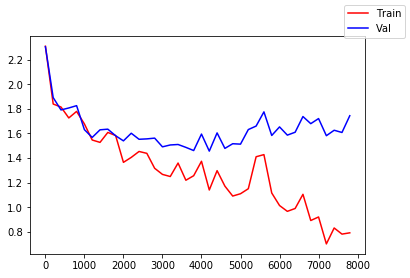

In [98]:
FCN.plot()

## Part 2

In [ ]:
layer_dimensions = [3072,..,.., 10]  # including the input and output layers  
# 3072 is the input feature size, 10 is the number of outputs in the final layer
FCN = FullyConnectedNetwork(layer_dimensions, lambd=0.1)
FCN.train(X_train, Y_train, max_iters=10000, batch_size=200, learning_rate=0.0001, validate_every=200)
# lambd, the L2 regularization penalty hyperparamter will not be 0 for this part
y_predicted = FCN.evaluate(X_test)  # print accuracy on test set

## Extra Credit